In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import mnist
from torchvision import transforms
import matplotlib.pyplot as plt
from torchinfo import summary

In [2]:
#定义网络结构
class Net(nn.Module):
    def __init__(self, in_c, out_c):
        super(Net, self).__init__()
        
        # 定义全连接层
        self.fc1 = nn.Linear(in_c, 512)
        # 定义激活层
        self.act1 = nn.ReLU(inplace=True)

        self.fc2 = nn.Linear(512, 256)
        self.act2 = nn.ReLU(inplace=True)

        self.fc3 = nn.Linear(256, 128)
        self.act3 = nn.ReLU(inplace=True)

        self.fc4 = nn.Linear(128, out_c)

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.act3(self.fc3(x))
        x = self.fc4(x)

        return x 

# 构建网络
net = Net(784, 10)
summary(net)

Layer (type:depth-idx)                   Param #
Net                                      --
├─Linear: 1-1                            401,920
├─ReLU: 1-2                              --
├─Linear: 1-3                            131,328
├─ReLU: 1-4                              --
├─Linear: 1-5                            32,896
├─ReLU: 1-6                              --
├─Linear: 1-7                            1,290
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0

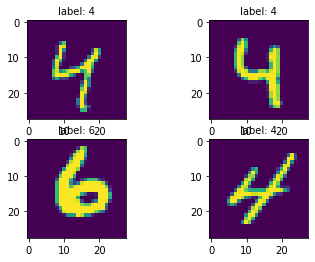

In [3]:
# 准备数据集
# 训练集
train_set = mnist.MNIST('./data', train=True, transform=transforms.ToTensor(), download=True)
# 测试集
test_set = mnist.MNIST('./data', train=False, transform=transforms.ToTensor(), download=True)
# 训练集载入器
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
# 测试集载入器
test_data = DataLoader(test_set, batch_size=128, shuffle=False) 

# 可视化数据
import random
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    idx = random.randint(0, len(train_set))
    digit_0 = train_set[idx][0].numpy()
    digit_0_image = digit_0.reshape(28, 28)
    ax.imshow(digit_0_image, interpolation="nearest")
    ax.set_title('label: {}'.format(train_set[idx][1]), fontsize=10, color='black')
plt.show()

In [4]:
# 定义损失函数--交叉熵
criterion = nn.CrossEntropyLoss()

# 定义优化器---随机梯度下降
optimizer = optim.SGD(net.parameters(), lr=1e-2, weight_decay=5e-4)

In [5]:
# 开始训练
# 记录训练损失
losses = []
# 记录训练精度
acces = []
# 记录测试损失
eval_losses = []
# 记录测试精度
eval_acces = []
# 设置迭代次数
nums_epoch = 2
for epoch in range(nums_epoch):
    train_loss = 0
    train_acc = 0
    net = net.train()
    for batch, (img, label) in enumerate(train_data):
        
        img = img.reshape(img.size(0), -1)
        img = Variable(img)
        label = Variable(label)

        # 前向传播
        out = net(img)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 记录误差
        train_loss += loss.item()
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]

        if (batch + 1) % 200 == 0:
            print('[INFO] Epoch-{}-Batch-{}: Train: Loss-{:.4f}, Accuracy-{:.4f}'.format(epoch + 1,
                                                                                 batch+1,
                                                                                 loss.item(),
                                                                                 acc))
        train_acc += acc

    losses.append(train_loss / len(train_data))
    acces.append(train_acc / len(train_data))

    eval_loss = 0
    eval_acc = 0
    # 测试集不训练
    for img, label in test_data:
        img = img.reshape(img.size(0),-1)
        img = Variable(img)
        label = Variable(label)

        out = net(img)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()

        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]

        eval_acc += acc
    eval_losses.append(eval_loss / len(test_data))
    eval_acces.append(eval_acc / len(test_data))

    print('[INFO] Epoch-{}: Train: Loss-{:.4f}, Accuracy-{:.4f} | Test: Loss-{:.4f}, Accuracy-{:.4f}'.format(
        epoch + 1, train_loss / len(train_data), train_acc / len(train_data), eval_loss / len(test_data),
        eval_acc / len(test_data))) 

[INFO] Epoch-1-Batch-200: Train: Loss-2.2793, Accuracy-0.2344
[INFO] Epoch-1-Batch-400: Train: Loss-2.2514, Accuracy-0.5312
[INFO] Epoch-1-Batch-600: Train: Loss-2.1626, Accuracy-0.6094
[INFO] Epoch-1-Batch-800: Train: Loss-1.9882, Accuracy-0.4844
[INFO] Epoch-1: Train: Loss-2.1522, Accuracy-0.4273 | Test: Loss-1.5562, Accuracy-0.6214
[INFO] Epoch-2-Batch-200: Train: Loss-0.9383, Accuracy-0.7969
[INFO] Epoch-2-Batch-400: Train: Loss-0.8937, Accuracy-0.7500
[INFO] Epoch-2-Batch-600: Train: Loss-0.6831, Accuracy-0.7812
[INFO] Epoch-2-Batch-800: Train: Loss-0.4696, Accuracy-0.8906
[INFO] Epoch-2: Train: Loss-0.8171, Accuracy-0.7801 | Test: Loss-0.4920, Accuracy-0.8610


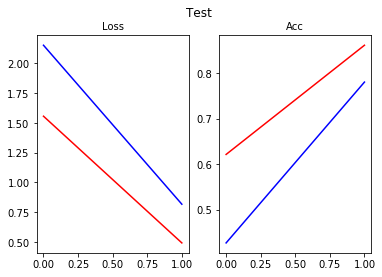

In [6]:
plt.figure()
plt.suptitle('Test', fontsize=12)
ax1 = plt.subplot(1, 2, 1)
ax1.plot(eval_losses, color='r')
ax1.plot(losses, color='b')
ax1.set_title('Loss', fontsize=10, color='black')
ax2 = plt.subplot(1, 2, 2)
ax2.plot(eval_acces, color='r')
ax2.plot(acces, color='b')
ax2.set_title('Acc', fontsize=10, color='black')
plt.show()